In [2]:
!pip install astropy[recommended] --upgrade


[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


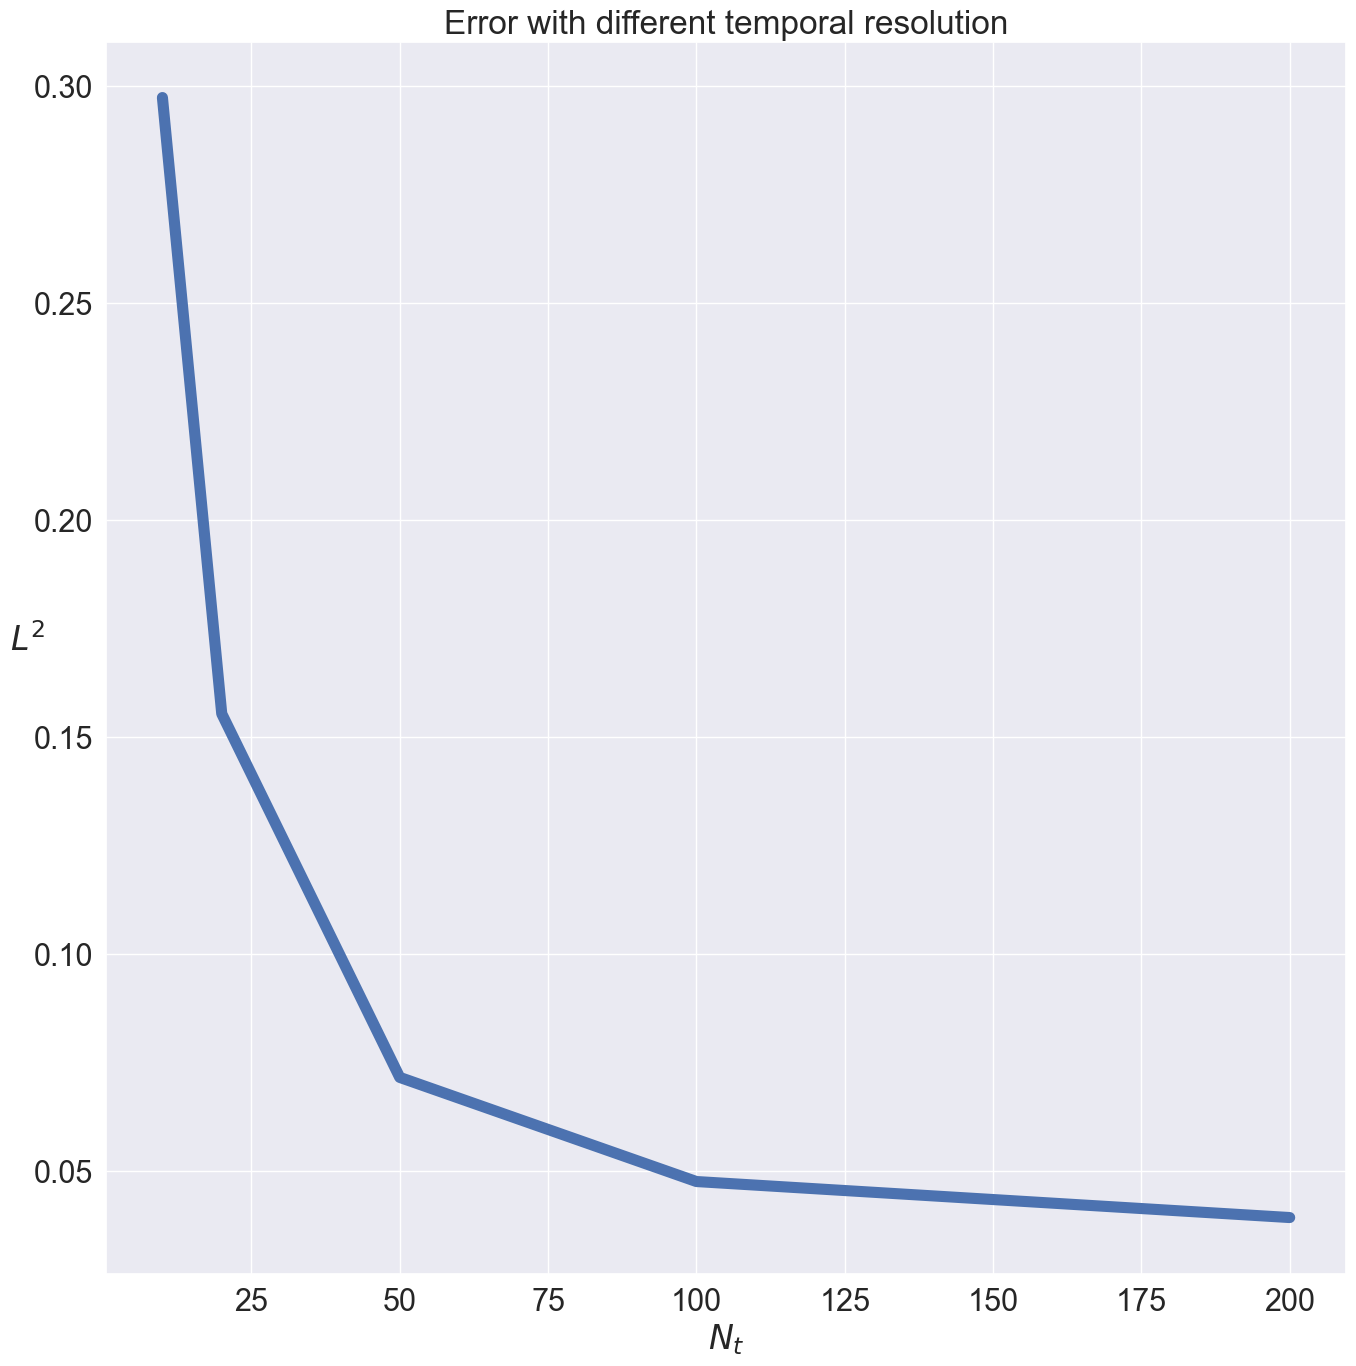

In [3]:
import os
from copy import copy
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.table import Table
import pandas as pd
import numpy as np

sns.set(font_scale=2)
errors = [0.2973 , 0.1553 , 0.0715 , 0.0475, 0.0392]
t = [10, 20, 50, 100, 200]
fig = plt.figure(figsize=(16, 16))
plt.title('Error with different temporal resolution')
plt.xlabel(r"$N_t$")
plt.ylabel(r"${L}^2$", style='italic', rotation='horizontal')
plt.plot(t, errors, linewidth=8)
# plt.xticks(t, t)

In [4]:
hypersonics_path = os.path.join('..', 'outputs', 'metrics', 'hypersonics_zero_shot_noise')
noise_levels = [0, 10, 20, 30, 50, 100]
# noise_levels = [0, 100, 200, 300]

tabs = []
for noise_level in noise_levels:
    if noise_level == 0:
        file_name = f'Hypersonics_N_1_M_10_nx_256_ny_256_time_steps_21.txt'
    else:
        file_name = f'Hypersonics_N_1_M_10_nx_256_ny_256_time_steps_21_noise_{noise_level}.txt'
    tab = Table.read(os.path.join(hypersonics_path, file_name), format='latex').to_pandas()
    tab.rename(columns={tab.columns[1]: fr'$\gamma = {noise_level / 100.}$'}, inplace=True)

    tab.set_index(tab.columns[0], inplace=True)
    tab.rename_axis(None, inplace=True)
    tabs.append(tab)
noise_df = pd.concat(tabs, axis=1)
noise_df

,$\gamma = 0.0$,$\gamma = 0.1$,$\gamma = 0.2$,$\gamma = 0.3$,$\gamma = 0.5$,$\gamma = 1.0$
DiTTO,0.0303,0.0360,0.0464,0.0591,0.0921,0.203
DiTTO-point,0.0152,0.0155,0.0167,0.0188,0.0253,0.054
FNO,0.0241,0.0795,0.1519,0.2229,0.3544,0.608


In [16]:
ditto_errors = np.array(noise_df.loc['DiTTO'].values.tolist())
ditto_point_errors = np.array(noise_df.loc['DiTTO-point'].values.tolist())
fno_errors = np.array(noise_df.loc['FNO'].values.tolist())

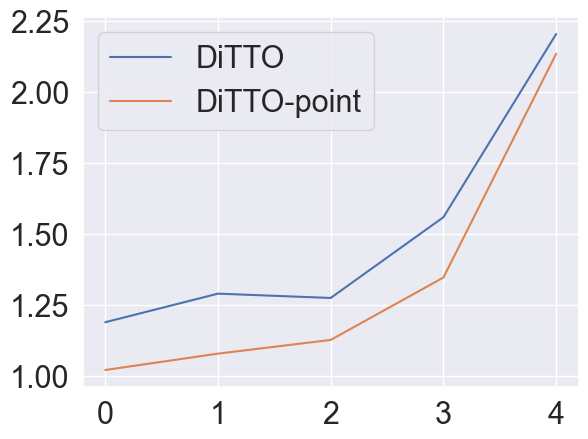

In [29]:
plt.plot(ditto_errors[1:] / ditto_errors[:-1], label='DiTTO')
plt.plot(ditto_point_errors[1:] / ditto_point_errors[:-1], label='DiTTO-point')
# plt.plot(fno_errors[1:] / fno_errors[:-1], label='FNO')
plt.legend()
plt.show()

In [9]:
print(noise_df.to_latex(float_format="{:0.4f}".format))

\begin{tabular}{lrrrrrr}
\toprule
 & $\gamma = 0.0$ & $\gamma = 0.1$ & $\gamma = 0.2$ & $\gamma = 0.3$ & $\gamma = 0.5$ & $\gamma = 1.0$ \\
\midrule
DiTTO & 0.0303 & 0.0360 & 0.0464 & 0.0591 & 0.0921 & 0.2030 \\
DiTTO-point & 0.0152 & 0.0155 & 0.0167 & 0.0188 & 0.0253 & 0.0540 \\
FNO & 0.0241 & 0.0795 & 0.1519 & 0.2229 & 0.3544 & 0.6080 \\
\bottomrule
\end{tabular}



In [142]:
noise_df = noise_df.reindex(['DiTTO-point', 'DiTTO', 'FNO'])
noise_df

,$\gamma = 0.0$,$\gamma = 0.1$,$\gamma = 0.2$,$\gamma = 0.3$,$\gamma = 0.5$,$\gamma = 1.0$
DiTTO-point,0.0152,0.0155,0.0167,0.0188,0.0253,0.054
DiTTO,0.0303,0.0360,0.0464,0.0591,0.0921,0.203
FNO,0.0241,0.0795,0.1519,0.2229,0.3544,0.608


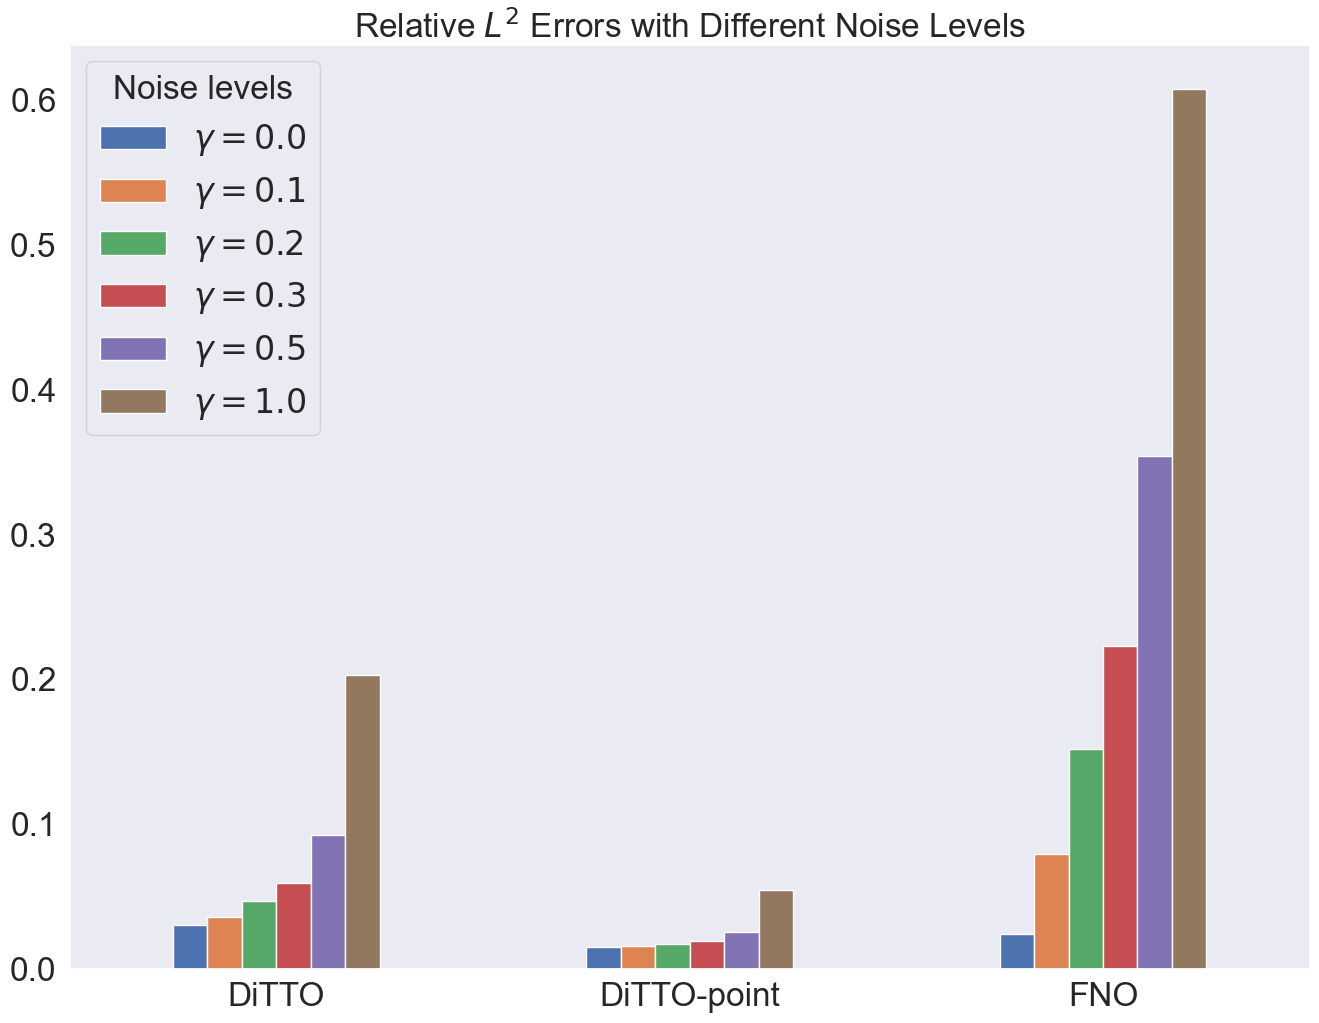

In [30]:
sns.set_style("dark")
fig, ax = plt.subplots()
ax = noise_df.plot.bar(figsize=(16, 12), rot=0, fontsize=24, ax=ax, logy=False)
plt.legend(title='Noise levels', fontsize=24)
plt.title(r'Relative ${L^2}$ Errors with Different Noise Levels', fontsize=24, pad=5)
plt.show()

In [46]:
import torch
data_path = os.path.join('..', 'data', 'hypersonics', 'Hypersonics_N_1_T_10_nx_256_ny_256')
data_dict = np.load(os.path.join(data_path, 'raw_data.npy'), mmap_mode=None, allow_pickle=True).item()
noise_dict = {}
min_list = []
max_list = []

noise_levels = [0, 100, 200, 300, 400, 500]

np.random.seed(0)
for noise_level in noise_levels:
    val = copy(data_dict['x_train'])
    std = np.std(data_dict['x_train'][0][np.where(data_dict['x_train'][0] != -20.)])  # np.std(val)
    # std = np.std(val)
    noise_dict[noise_level] = val + np.random.normal(0, std * noise_level / 100., val.shape)
    min_list.append(np.min(noise_dict[noise_level]))
    max_list.append(np.max(noise_dict[noise_level]))


In [43]:
data_dict['x_train'].shape

(1, 256, 256)

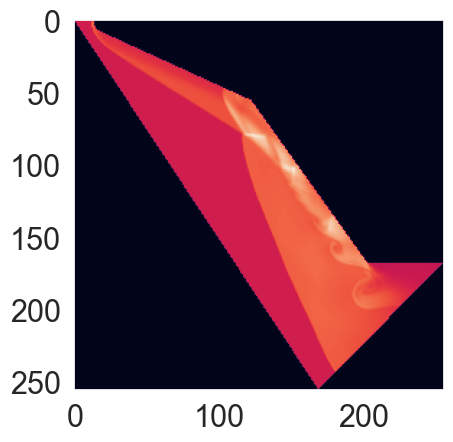

In [45]:
plt.imshow(data_dict['x_train'][0])
plt.show()

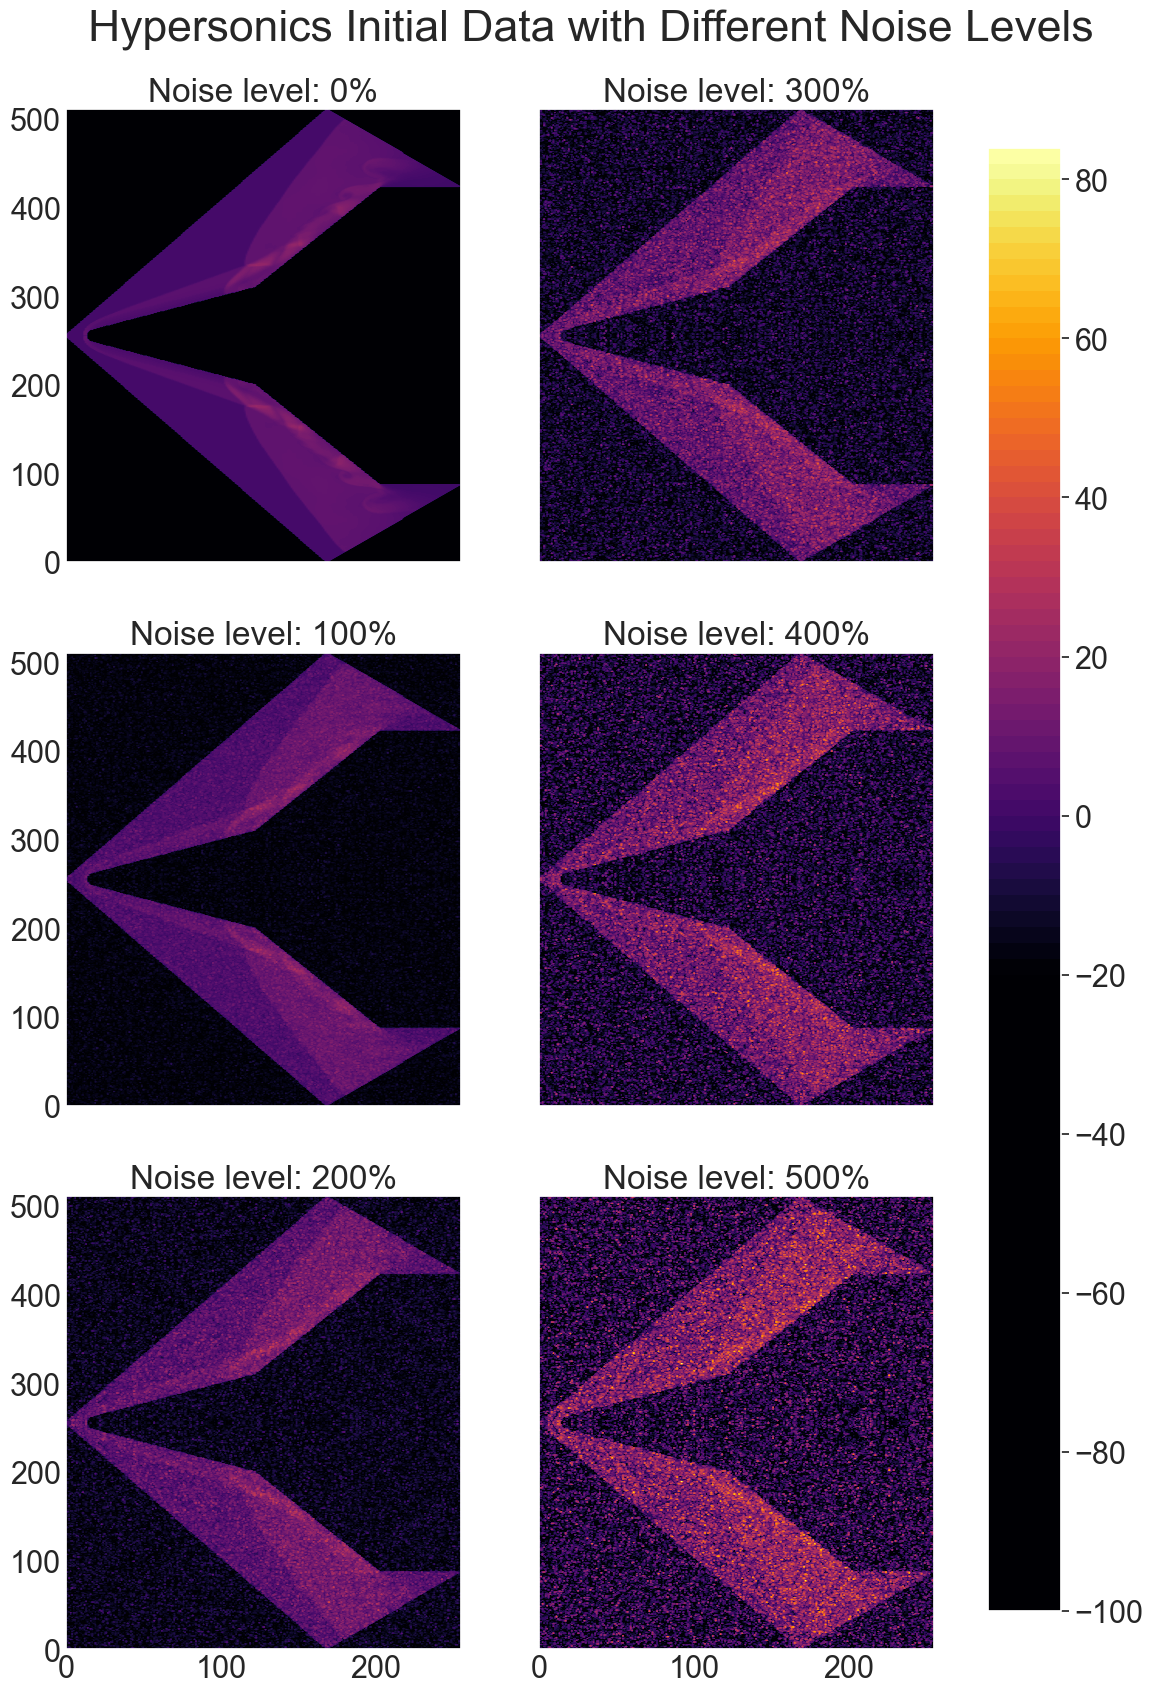

In [47]:
fig, ax = plt.subplots(3, 2, figsize=(14, 20), sharey=True, sharex=True)

vmin = np.max(min_list)
vmax = np.max(max_list)
row, col = 0, 0
for n, noise_level in enumerate(noise_levels):
    if n < 3:
        row = n
        col = 0
    else:
        row = n - 3
        col = 1
    
    tensor = torch.from_numpy(noise_dict[noise_level][0, :, :])
    flip270 = torch.rot90(tensor, k=3)
    flip270_lr = torch.fliplr(flip270)
    concat_tensor = torch.cat((flip270, flip270_lr), dim=1)
    
    im = ax[row, col].contourf(concat_tensor.T, levels=100, cmap='inferno', vmin=vmin, vmax=vmax)
    ax[row, col].set_title(f'Noise level: {noise_level}%')
    ax[row, col].tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Hypersonics Initial Data with Different Noise Levels', fontsize=32, y=0.93)
fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.95)
plt.savefig('hypersonics_noise_levels.png', dpi=300, bbox_inches='tight')